In [1]:
# SETUP IMPORTS
import sys # 
import plotly.io as pio
import pandas as pd
pio.renderers.default = 'png' # This sets plotly graphs to be NOT interactive (= 'png')
sys.path.append("scripts")
from session_pipeline import run_heuristics

# 🧪 Quality Control Report

## 📑 Table of Contents

- [1. Introduction & Heuristics](#1-introduction--heuristics)
- [2. Summary Table (Final Result)](#2-summary-table-final-result)

---

- [3. Phase 0: Raw Data](#3-phase-0-raw-data)
- [4. Phase 1: Structural Checks](#4-phase-1-structural-checks)
- [5. Phase 2: Quality Filters](#5-phase-2-quality-filters)

---

- [6. Full Drop Summary Table & Final Plots](#6-full-drop-summary-table--final-plots)
- [7. Supplemental Parameter Review (No Heuristics Applied)](#7-supplemental-parameter-review-no-heuristics-applied)

---

- [8. User Notes & Additional Analysis](#8-user-notes--additional-analysis)

## 1. Introduction & Heuristics

This report presents a multi-phase quality control (QC) pipeline applied to session-level data from ADNI. The goal is to iteratively filter out problematic sessions based on predefined heuristics, ensuring that only high-quality, analyzable data progresses through downstream preprocessing and analysis pipelines (e.g., Clinica BIDS conversion, fMRI preprocessing, etc.).

Each phase applies one or more heuristics and saves a snapshot of the dataset after that phase. These snapshots allow us to evaluate the impact of each heuristic on the dataset size and quality.

---

### 🔍 Heuristics Applied

Below is a list of all heuristics used in this pipeline, including their parameter target and the filtering criteria applied:

| Parameter              | Criteria                                                                 |
|------------------------|--------------------------------------------------------------------------|
| **BIDS**               | Sessions flagged due to known errors in Clinica BIDS conversion.         |
| **Missing Data**       | Sessions where required `NIfTI` or `JSON` files are missing **after Clinica/BIDS conversion**, even if no error was reported.                       |
| **ScanDepth (dim₃×pixdim₃)** | Sessions where scan depth (`dim₃ × pixdim₃`) is **outside the range [155, 180]**.     |
| **Scan Duration**      | Sessions where total duration (`TR × volumes`) is **less than 300 seconds (5 minutes)**. |
| **RepetitionTime (TR)**| Sessions where TR falls outside the acceptable ranges of [0.5–1.0] or [2.9–3.1] seconds. |
| **PercentPhaseFOV**    | Sessions with `PercentPhaseFOV ≤ 72`, indicating potential spatial undersampling. |
| **CoilString**         | Sessions using nonstandard or problematic coils such as `Q-Body` or `BODY`. |

Each of these heuristics is applied in order across three main phases:

- **Phase 0 – Raw Data Checks**: Remove sessions with completely missing files or known failures (Clinica).
- **Phase 1 – Structural Criteria**: Remove sessions with abnormal scan depth, repetition time, and scan duration.
- **Phase 2 – Additional Quality Filters**: Remove sessions with undersampled fields of view or invalid coil settings.

The next section shows a table that summarizes the cumulative effect of each heuristic, showing how many sessions were removed and how many remain.


## 2. Summary Table (Final Result)

#### Initial Session Count: 2893 (1153 subjects)

| Phase | Parameter | Criteria | Rows Dropped | Remaining Rows |
|-------|-----------|----------|--------------|----------------|
| Phase 0 | BIDS | Sessions flagged due to known errors in Clinica BIDS conversion. | 0 | 2893 |
|  | Missing Data | Sessions where required NIfTI or JSON files are missing after Clinica conversion. | 141 | 2752 |
|  | T1w Image Missing | Session does not have a T1-weighted image. | 69 | 2683 |
| Phase 1 | ScanDepth (dim3×pixdim3) | Scan Depth (dim₃ × pixdim₃) is outside the range [155, 180]. | 25 | 2658 |
|  | RepetitionTime (TR) | Sessions where TR falls outside [0.5–1.0] or [2.9–3.1] seconds. | 27 | 2631 |
|  | Scan Duration | Sessions where total scan duration (TR × volumes) is less than 5 minutes. | 7 | 2624 |
| Phase 2 | PercentPhaseFOV | A session with an unusually low value of ≤ 72. | 1 | 2623 |
|  | CoilString | Sessions that use Q-BODY or BODY coils. | 2 | 2621 |
| **TOTAL** | — | — | **272** | **2621** |

#### Final Session Count: 2621 (1105 subjects)

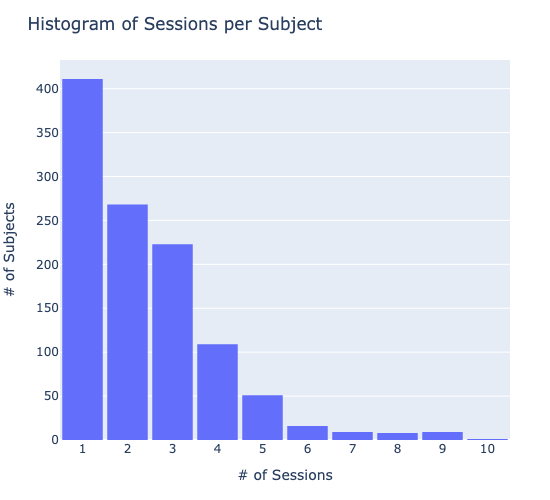

In [ ]:
report = run_heuristics("../create_mastersheet/data/statadni/anchor_plus_dicom_nifti_struct.csv")

## 3. Phase 0: Raw Data

In [16]:
report.render_phase0_summary()


Three checks were applied:

- **BIDS**: Sessions flagged due to known errors in Clinica BIDS conversion.
- **Missing Data**: Sessions where required `NIfTI` or `JSON` files are missing **after Clinica/BIDS conversion**, even if no error was reported.
- **T1w Image Missing**: Session does not have a T1-weighted image. 

These filters ensure that only sessions with the core imaging files required for analysis proceed to structural and quality-based checks in later phases.

### Dropped Summary

| Heuristic              | Sessions Dropped |
|------------------------|------------------|
| BIDS                   | 0         |
| Missing Data           | 141      |
| T1w Image Missing      | 69          |
| Remaining After Phase 0| 2683      |


In [18]:
report.dropped_dfs["filter_missing_data"][["Image_ID", "Subject_ID", "VISCODE", "Path", "JSON_path"]].head()

,Image_ID,Subject_ID,VISCODE,Path,JSON_path
4,569636,002_S_0413,m108,/N/project/statadni/20231212_ADR012021_UtahBac...,/N/project/statadni/20250922_Saige/adni_db/bid...
12,418009,002_S_1261,m84,/N/project/statadni/20231212_ADR012021_UtahBac...,/N/project/statadni/20250922_Saige/adni_db/bid...
21,505156,002_S_2010,m60,/N/project/statadni/20231212_ADR012021_UtahBac...,/N/project/statadni/20250922_Saige/adni_db/bid...
27,780966,002_S_2073,m72,/N/project/statadni/20231212_ADR012021_UtahBac...,/N/project/statadni/20250922_Saige/adni_db/bid...
33,573757,002_S_4213,m48,/N/project/statadni/20231212_ADR012021_UtahBac...,/N/project/statadni/20250922_Saige/adni_db/bid...


In [ ]:
missing_t1 = report.dropped_dfs["filter_missing_t1w"][["Image_ID", "Subject_ID", "VISCODE", "Path", "JSON_path"]]

In [ ]:
missing_t1.to_csv('missing_t1.csv', index=False) # set path to where you want to save the missing T1w report

In [20]:
missing_data = report.dropped_dfs["filter_missing_data"][["Image_ID", "Subject_ID", "VISCODE", "Path", "JSON_path"]]

In [ ]:
missing_data.to_csv('/missing_data.csv', index=False) # set path to where you want to save the missing data report

In [22]:
report.dropped_dfs["filter_missing_data_adnidap"][["Image_ID", "Subject_ID", "VISCODE", "Path", "JSON_path"]].head()

,Image_ID,Subject_ID,VISCODE,Path,JSON_path


## 4. Phase 1: Structural Checks

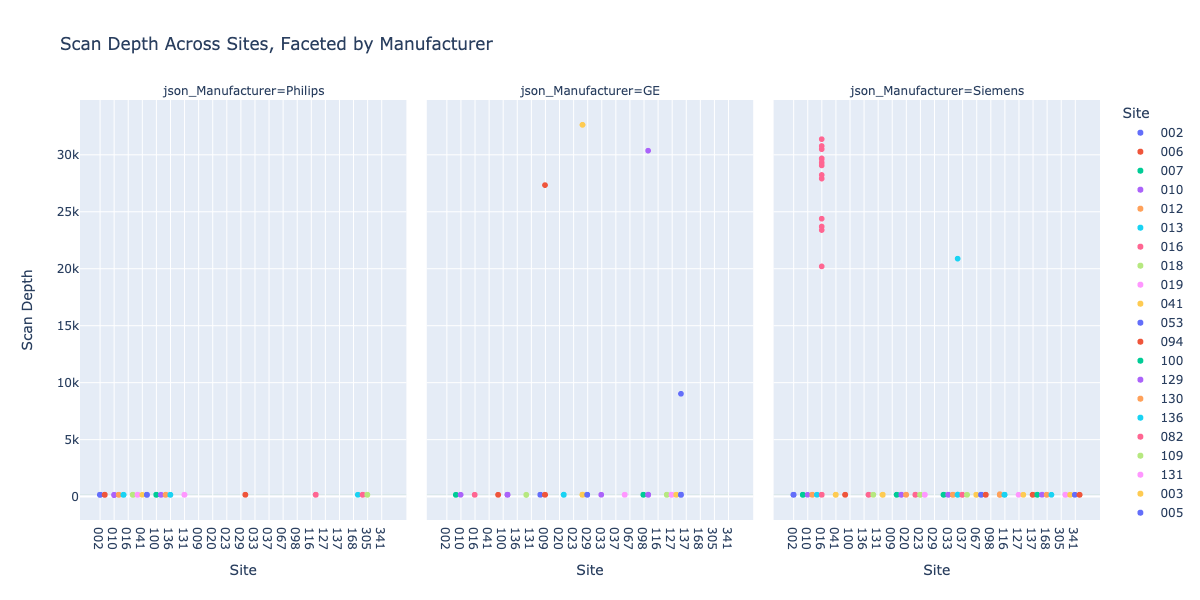

In [25]:
report.render_phase1_scan_plot(produce_html=False) # True will save an interactive plot as an HTML file

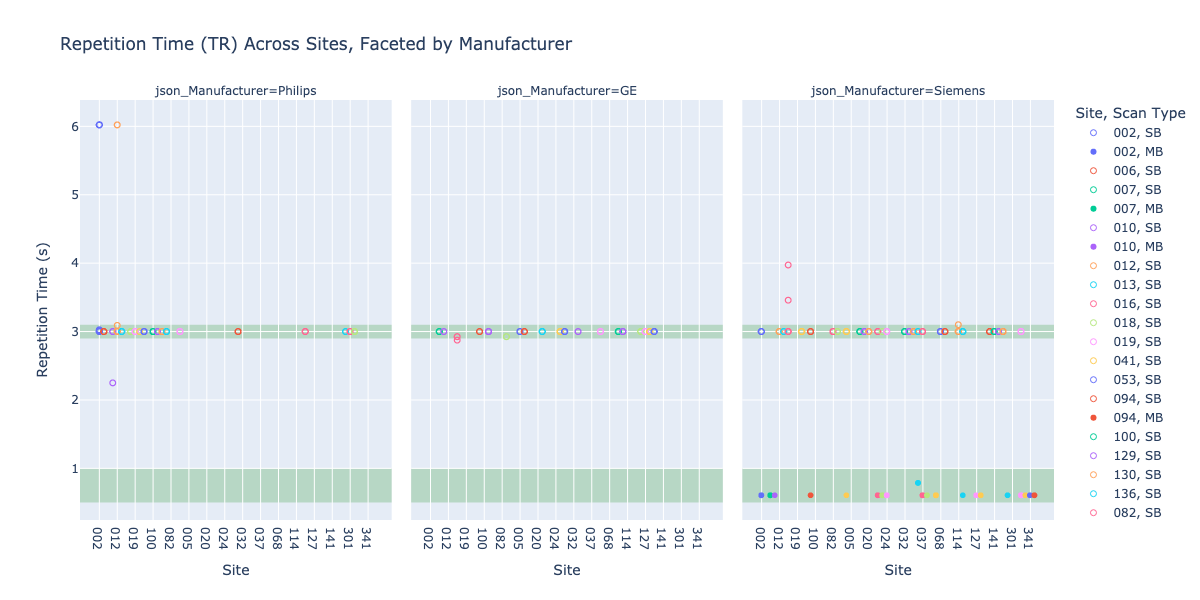

In [27]:
report.render_phase1_tr_plot(produce_html=False) 

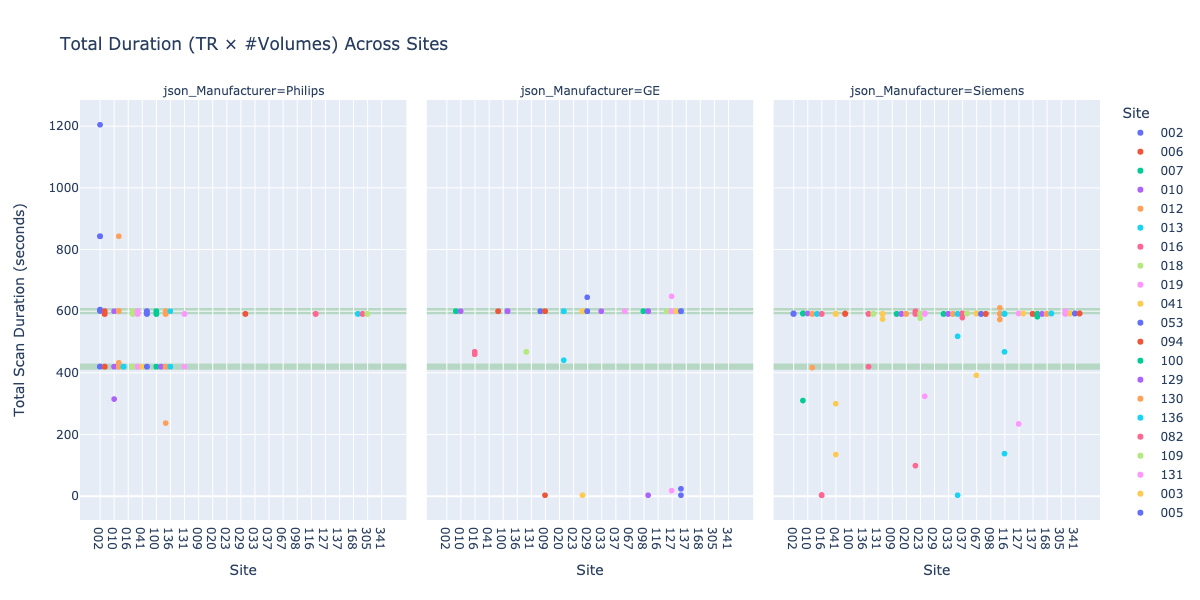

In [29]:
report.render_phase1_duration_plot(produce_html=False)

In [31]:
report.render_phase1_summary()


Three heuristics were evaluated:

- **ScanDepth (dim₃ × pixdim₃)**: Sessions with dim₃ × pixdim₃ < 155 were flagged.
- **RepetitionTime (TR)**: Sessions with TR outside [0.5–1.0] or [2.9–3.1] seconds were flagged.
- **Scan Duration**: Sessions where `TR × volumes` is < 300 seconds (i.e., under 5 minutes).

These thresholds are chosen to ensure structural and temporal resolution integrity.  
- ScanDepth values above 155 typically reflect sufficient anatomical coverage.  
- TR values within [0.5–1.0] or [2.9–3.1] seconds are considered standard for multiband and single-band protocols.  
- Short scans (<5 minutes) may indicate incomplete acquisitions.

The bullet points below summarize missing values by manufacturer, while the table highlights how many sessions were dropped by each heuristic.

### Missing Field Counts by Manufacturer
- **Philips**: 0 missing ScanDepth, 0 missing TR
- **Siemens**: 0 missing ScanDepth, 0 missing TR
- **GE**: 0 missing ScanDepth, 0 missing TR

### Dropped Summary

| Heuristic         | Sessions Dropped |
|------------------|------------------|
| ScanDepth         | 25     |
| RepetitionTime    | 30     |
| Scan Duration     | 27    |
| Dropped by All 3  | 2    |
| Remaining After Phase 1 | 2624 |

### Overlap Analysis

→ **Total dropped in Phase 1 = (25 + 30 + 27) − 2 = 82 − 2 = 59 sessions**  
→ **Remaining = 2683 − 59 = 2624 sessions**
    

## 5. Phase 2: Quality Filters

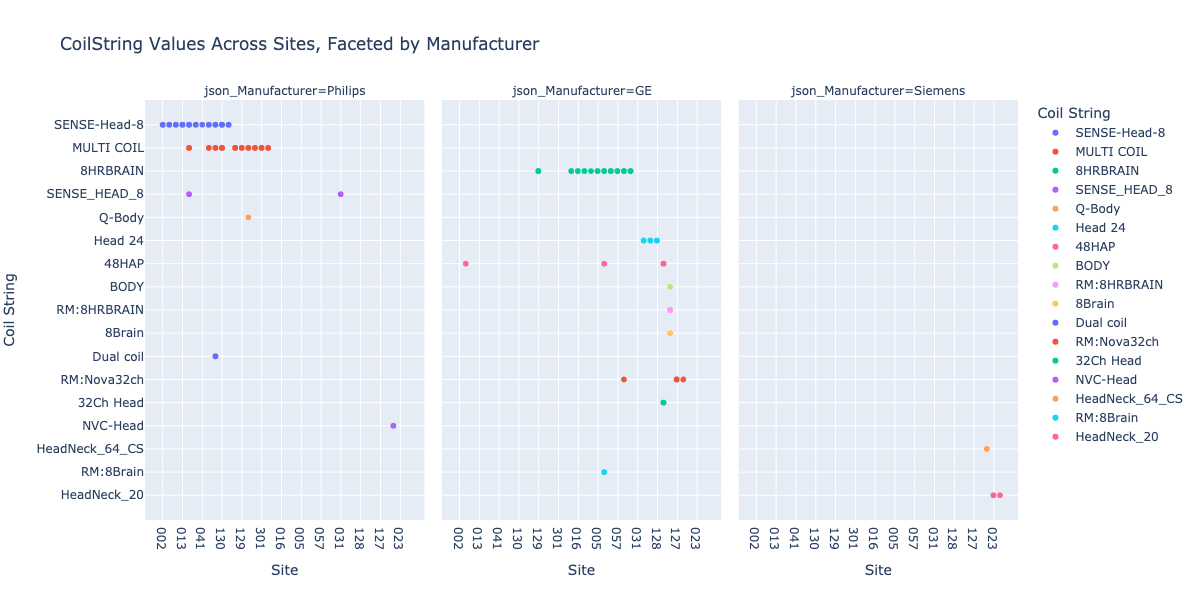

In [34]:
report.render_phase2_coil_plot(produce_html=False) # True will save an interactive plot as an HTML file

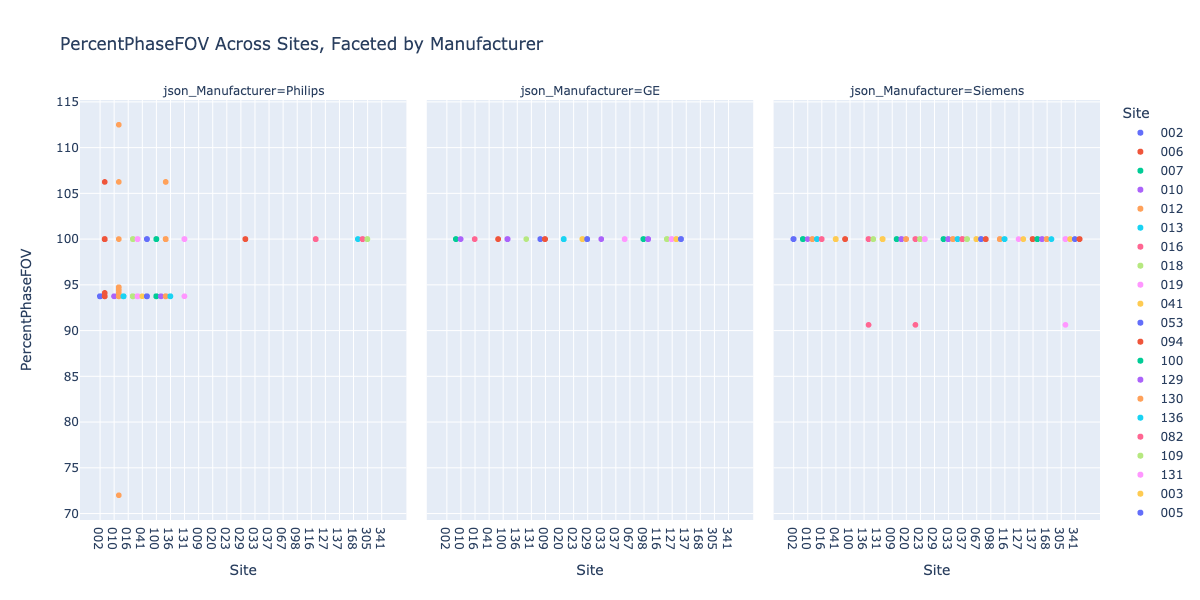

In [36]:
report.render_phase2_fov_plot(produce_html=False) # True will save an interactive plot as an HTML file

In [38]:
report.render_phase2_summary()


Two heuristics were evaluated:

- **PercentPhaseFOV**: Sessions with json_PercentPhaseFOV ≤ 72 were flagged.
- **CoilString**: Sessions that used Q-BODY or BODY coils were flagged for exclusion.

These filters were applied to ensure imaging consistency. An unusually low PercentPhaseFOV (e.g., 72%) may indicate problematic field coverage. Additionally, coils labeled Q-BODY or BODY are not used for brain imaging.

The bullet points below summarize missing values by manufacturer, while the table highlights how many sessions were dropped by each heuristic.

### Missing Field Counts by Manufacturer
- **Philips**: 0 missing PercentPhaseFOV, 0 missing CoilString
- **Siemens**: 0 missing PercentPhaseFOV, 1181 missing CoilString
- **GE**: 0 missing PercentPhaseFOV, 0 missing CoilString

### Dropped Summary

| Heuristic                | Sessions Dropped |
|--------------------------|------------------|
| PercentPhaseFOV          | 1    |
| CoilString               | 2   |
| Dropped by Both          | 0   |
| Remaining After Phase 2  | 2621      |

### Overlap Analysis

→ **Total dropped in Phase 2 = (1 + 2) − 0 = 3 sessions**  
→ **Remaining = 2624 − 3 = 2621 sessions**


## 6. Full Drop Summary Table & Final Plots

This section presents the final results of the quality control pipeline after all heuristic filters have been applied.

- **Full Drop Summary Table**: A comprehensive table listing all sessions removed during each phase of filtering, along with the specific reasons or heuristics responsible for their exclusion.
- **Missing Data Overview**: A table summarizing missingness across key fields in the final retained dataset.
- **Final Plots**: Visualizations of the cleaned cohort across key acquisition parameters (e.g., ScanDepth, Repetition Time, CoilString, PercentPhaseFOV), faceted by manufacturer and stratified by site. These plots reflect only the data that passed all structural and quality checks.

#### Initial Session Count: 2893 (1153 subjects)

| Phase | Parameter | Criteria | Rows Dropped | Remaining Rows |
|-------|-----------|----------|--------------|----------------|
| Phase 0 | BIDS | Sessions flagged due to known errors in Clinica BIDS conversion. | 0 | 2893 |
|  | Missing Data | Sessions where required NIfTI or JSON files are missing after Clinica conversion. | 141 | 2752 |
|  | T1w Image Missing | Session does not have a T1-weighted image. | 69 | 2683 |
| Phase 1 | ScanDepth (dim3×pixdim3) | Scan Depth (dim₃ × pixdim₃) is outside the range [155, 180]. | 25 | 2658 |
|  | RepetitionTime (TR) | Sessions where TR falls outside [0.5–1.0] or [2.9–3.1] seconds. | 27 | 2631 |
|  | Scan Duration | Sessions where total scan duration (TR × volumes) is less than 5 minutes. | 7 | 2624 |
| Phase 2 | PercentPhaseFOV | A session with an unusually low value of ≤ 72. | 1 | 2623 |
|  | CoilString | Sessions that use Q-BODY or BODY coils. | 2 | 2621 |
| **TOTAL** | — | — | **272** | **2621** |

#### Final Session Count: 2621 (1105 subjects)

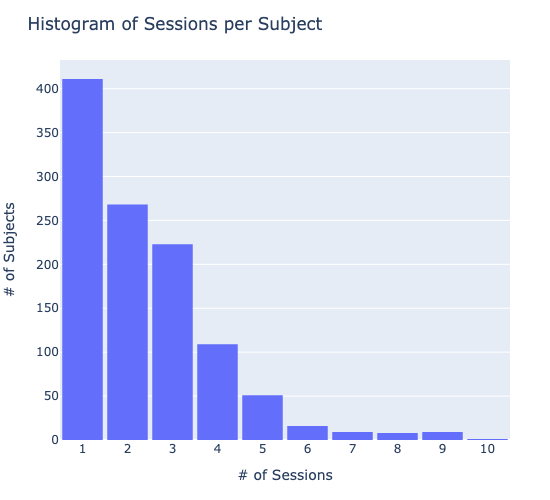

In [41]:
report.display_phase_summary()

In [43]:
report.render_final_missingness_by_manufacturer()

### Final Missing Data by Parameter (Faceted by Manufacturer)

| Parameter | Philips | Siemens | GE |
|-----------|---------|---------|----|
| RepetitionTime | 0 | 0 | 0 |
| MagneticFieldStrength | 0 | 0 | 0 |
| ManufacturersModelName | 0 | 0 | 0 |
| InstitutionName | 0 | 63 | 0 |
| MRAcquisitionType | 0 | 0 | 0 |
| SliceThickness | 0 | 0 | 0 |
| SpacingBetweenSlices | 0 | 0 | 0 |
| EchoTime | 0 | 0 | 0 |
| FlipAngle | 0 | 0 | 0 |
| PercentPhaseFOV | 0 | 0 | 0 |
| PercentSampling | 0 | 0 | 0 |
| EchoTrainLength | 0 | 220 | 524 |
| AcquisitionMatrixPE | 0 | 16 | 0 |
| PhaseEncodingDirection | 899 | 30 | 10 |
| CoilString | 0 | 1181 | 0 |
| MRAcquisitionFrequencyEncodingSteps | 779 | 1196 | 524 |
| PhaseEncodingAxis | 0 | 1167 | 514 |
| ScanDepth | 0 | 0 | 0 |

The following plots were generated from the filtered dataset after all heuristic checks were completed. They reflect the final, cleaned cohort and capture key acquisition parameters across sites and manufacturers.

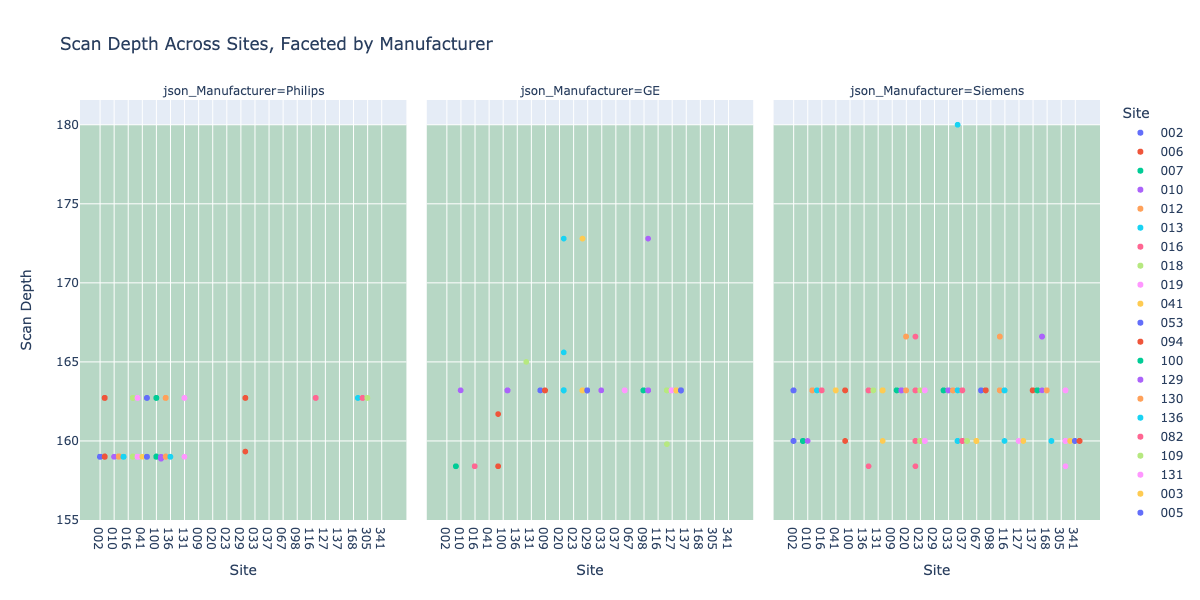

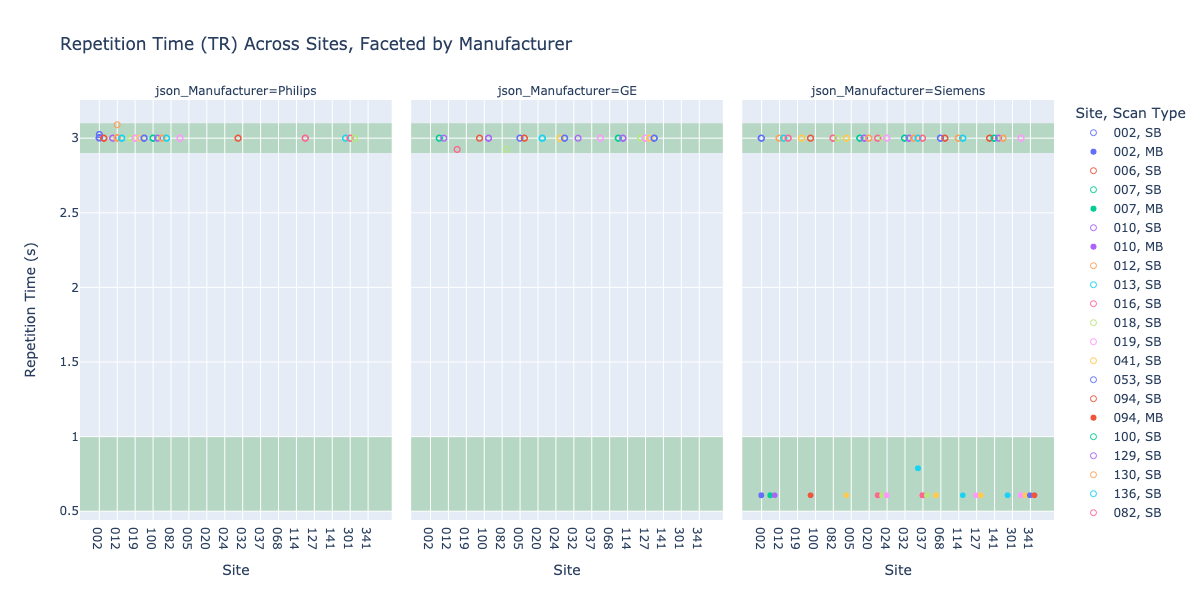

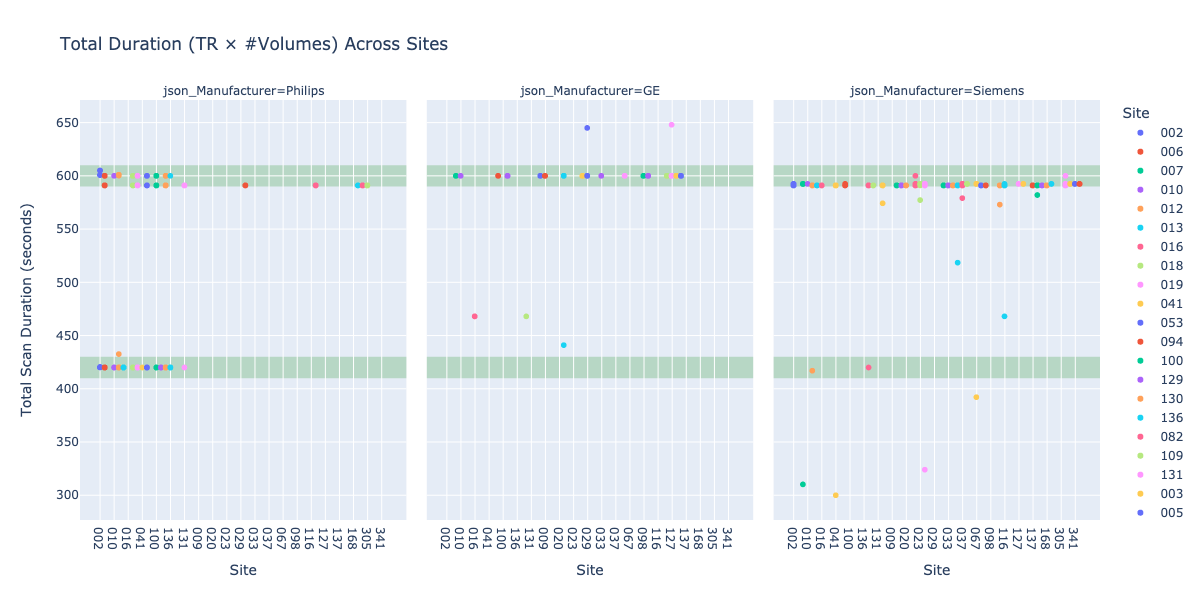

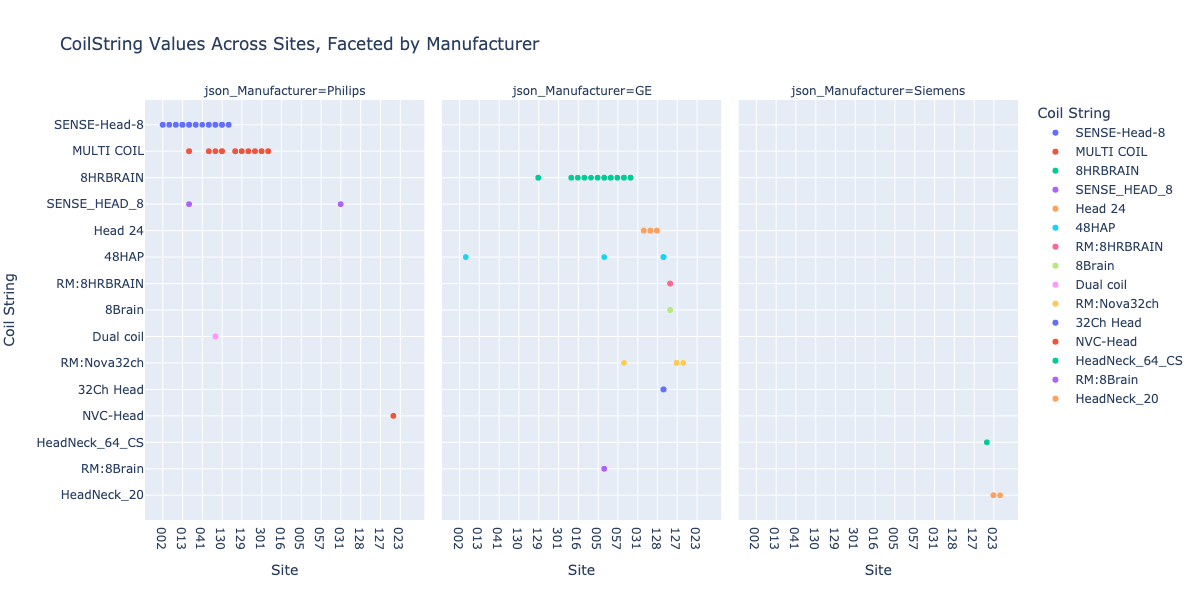

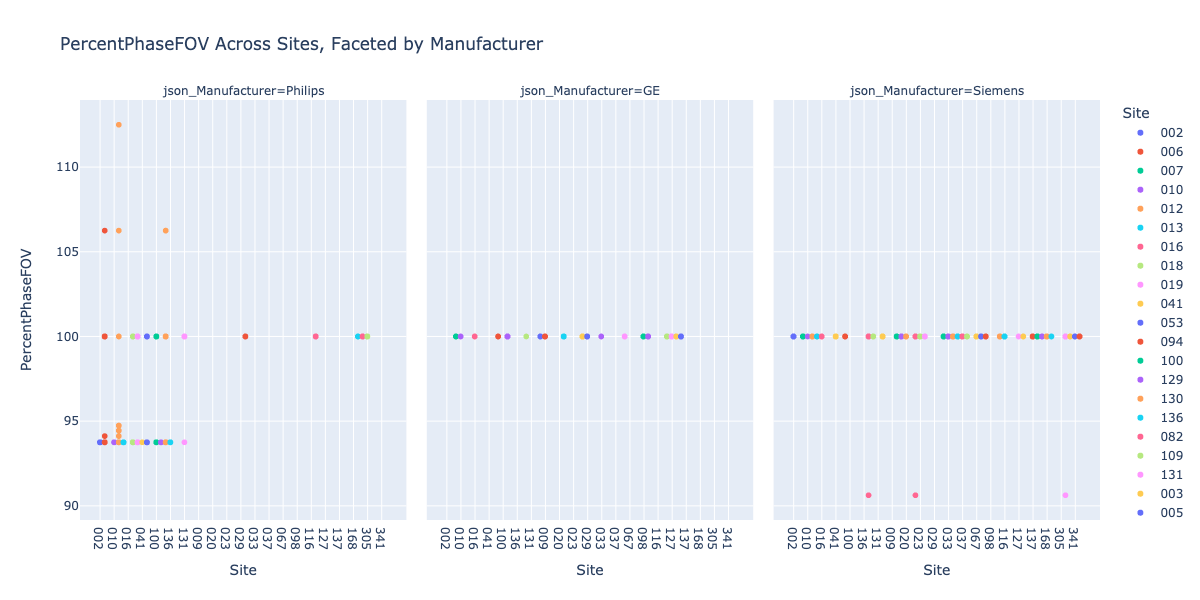

In [45]:
report.render_final_filtered_plots()

In [ ]:
report.df_current.to_csv('final_heuristics_applied_all_subjects_sessions.csv', index=False) # set path to where you want to save the final dataframe after all heuristics have been applied (this will be passed to MRIQC & fMRIPrep)

In [ ]:
df = report.df_current.copy()

In [ ]:
output_path = '/N/project/statadni/20250922_Saige/fmriprep/slurm/final_heuristics_applied_all_subjects_sessions_grouped_CLEAN.csv'

In [ ]:
# Function to clean VISCODE to format M### uppercase and zero padded
def clean_viscode(v):
    v = v.upper()
    if v.startswith('M'):
        num = v[1:]
        return 'M' + num.zfill(3)
    return v

In [ ]:
grouped = (
    df.groupby('Subject_ID')['VISCODE']
    .unique()
    .apply(lambda arr: sorted(clean_viscode(v) for v in arr))
    .reset_index()
)

grouped['sessions'] = grouped['VISCODE'].apply(lambda lst: ' '.join(lst))


# Select final columns
out = grouped[['Subject_ID', 'sessions']]

In [ ]:
out.head()

In [ ]:
# Save
out.to_csv(output_path, index=False)

## 7. Supplemental Parameter Review (No Heuristics Applied)

We reviewed a number of additional parameters that were not used to define heuristics. This section documents them for transparency. Parameters are grouped into two categories:

### A. Supplemental Plots Provided for Context Only

These parameters were not intended for heuristic development but are included to help visualize the dataset. They provide context for acquisition variability but do not reflect quality control criteria.

- **Multiband vs. Single-band Session Timeline**

- **Manufacturer Model Name** 

- **Institution Name** 

- **Echo Train Length** 

- **Acquisition Matrix PE** 

- **Phase Encoding Direction** 
  *Note: Not used in fMRIPrep due to the chosen unwarping method, but may be relevant for future harmonization efforts.*

- **Phase Encoding Axis** 

---

### B. Parameters Considered for Heuristic Use but Not Flagged

These parameters were reviewed as potential heuristic candidates, but no consistent quality issues were identified. In many cases, they were correlated with other filtered parameters or showed no problematic variation.

- **Magnetic Field Strength** 

- **MR Acquisition Type** 

- **Slice Thickness** 
  *Note: This is directly related to ScanDepth, which is computed as `SliceThickness × Number of Slices`.*

- **Spacing Between Slices** 
  *Note: Closely tied to SliceThickness and thus indirectly captured in ScanDepth.*

- **Flip Angle** 
  *Note: When sessions with poor Repetition Time (TR) are excluded, Flip Angle distributions become acceptable as well.*

- **Percent Sampling** 

- **MR Acquisition Frequency Encoding Steps** 

- **Echo Time**

/opt/anaconda3/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/opt/anaconda3/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



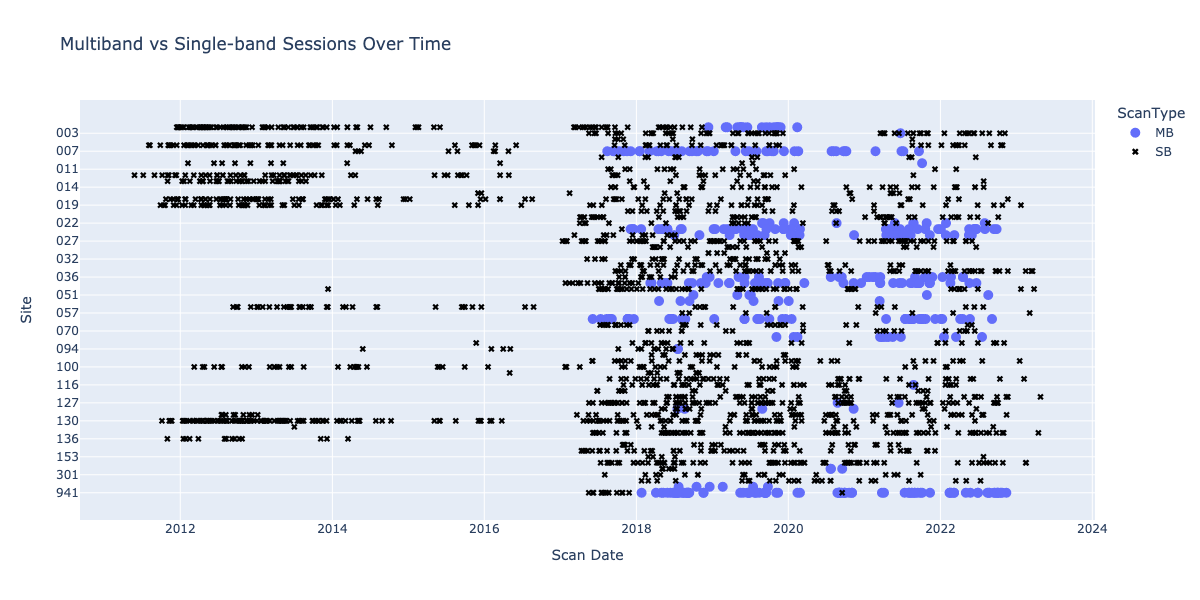

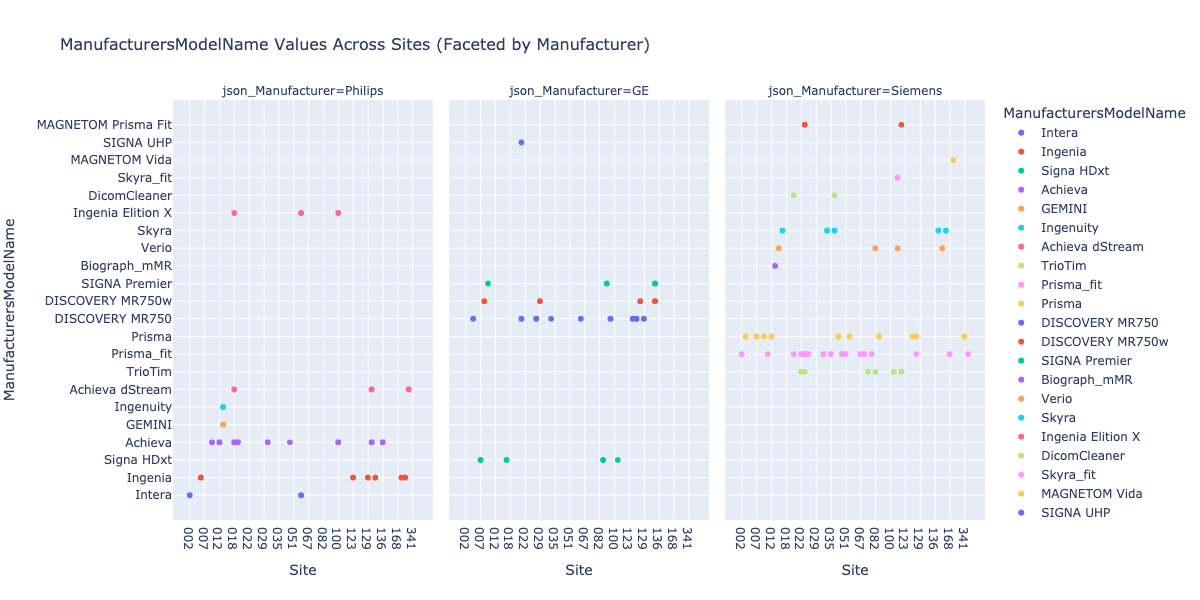

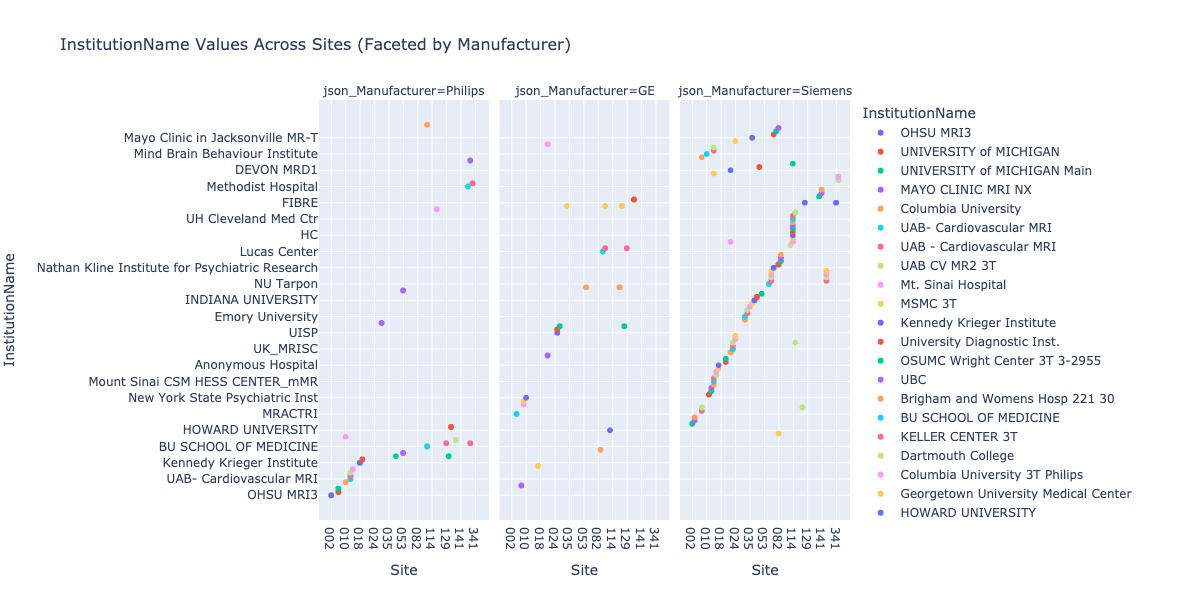

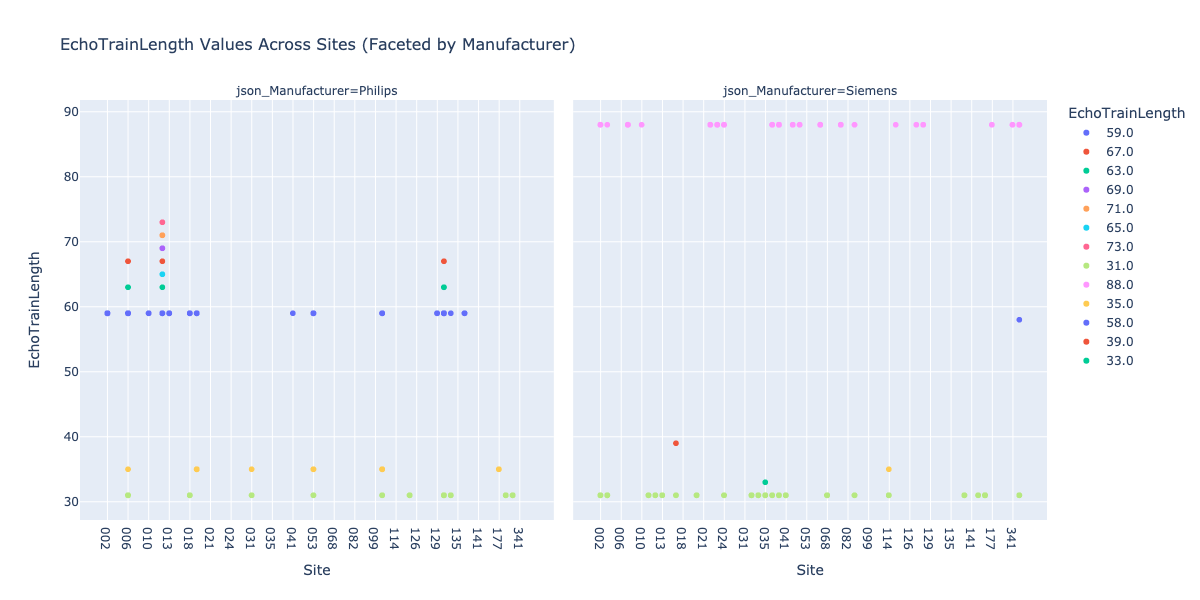

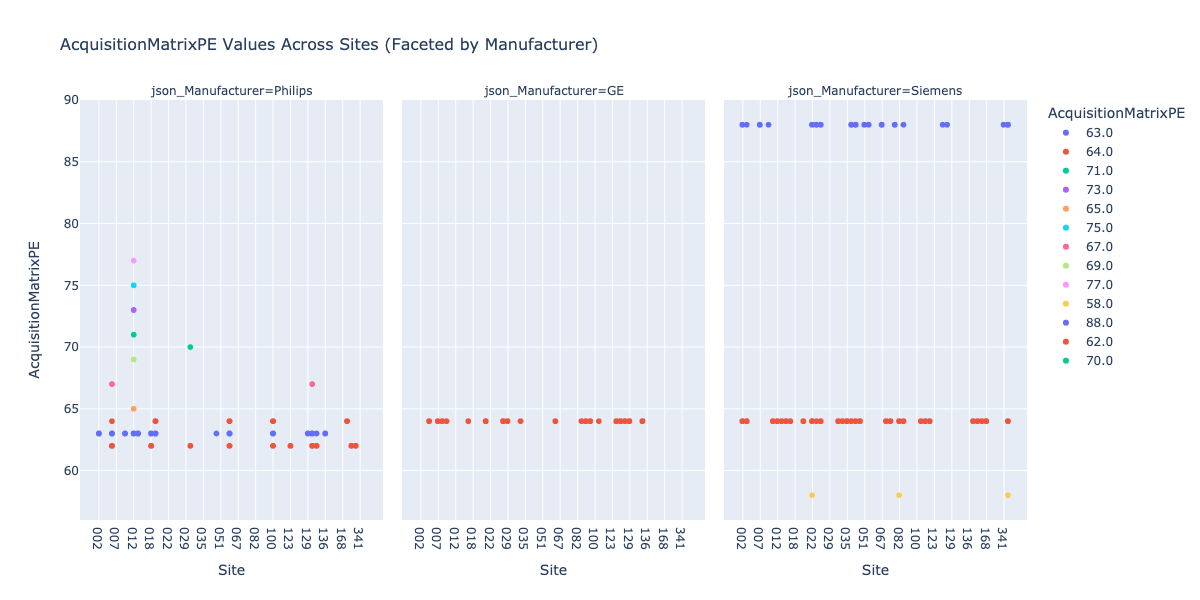

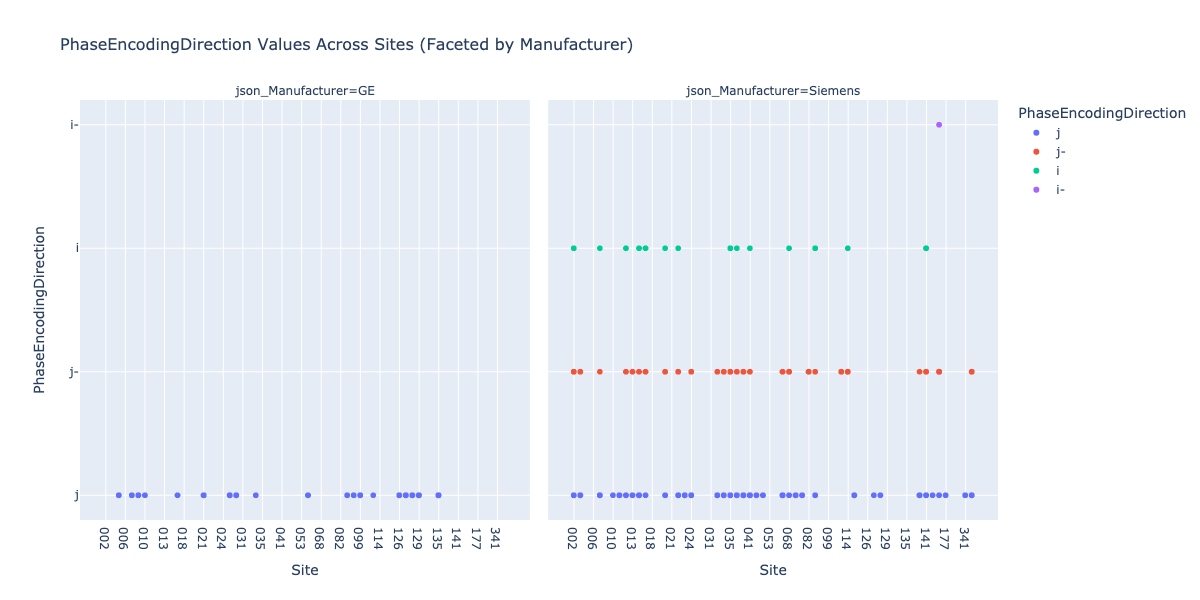

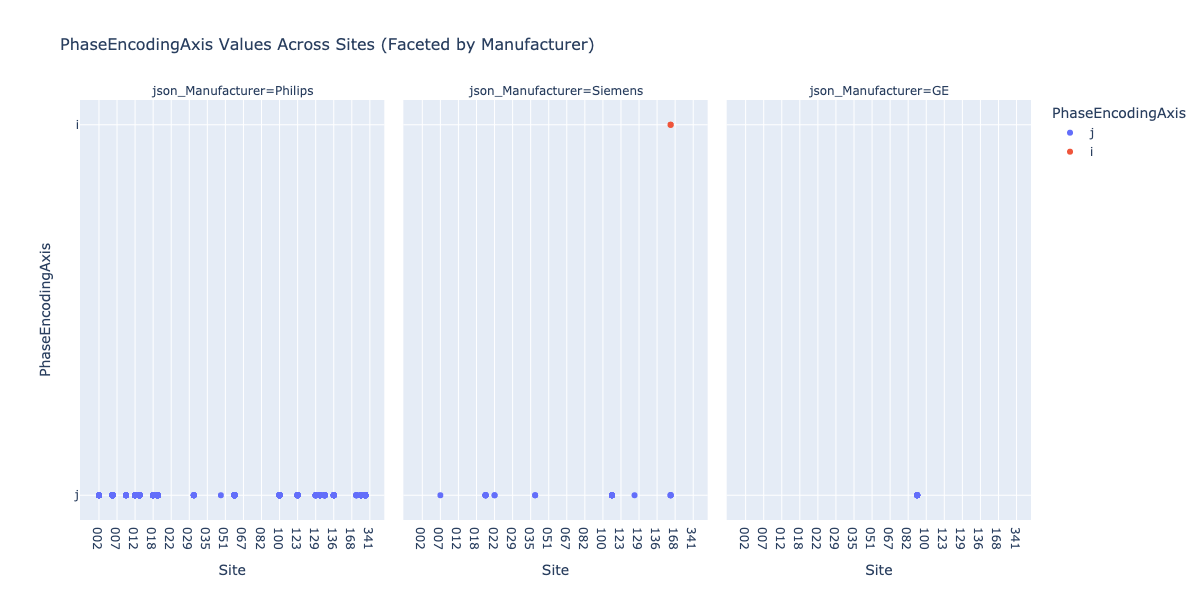

---

## B. Parameters Considered for Heuristic Use but Not Flagged


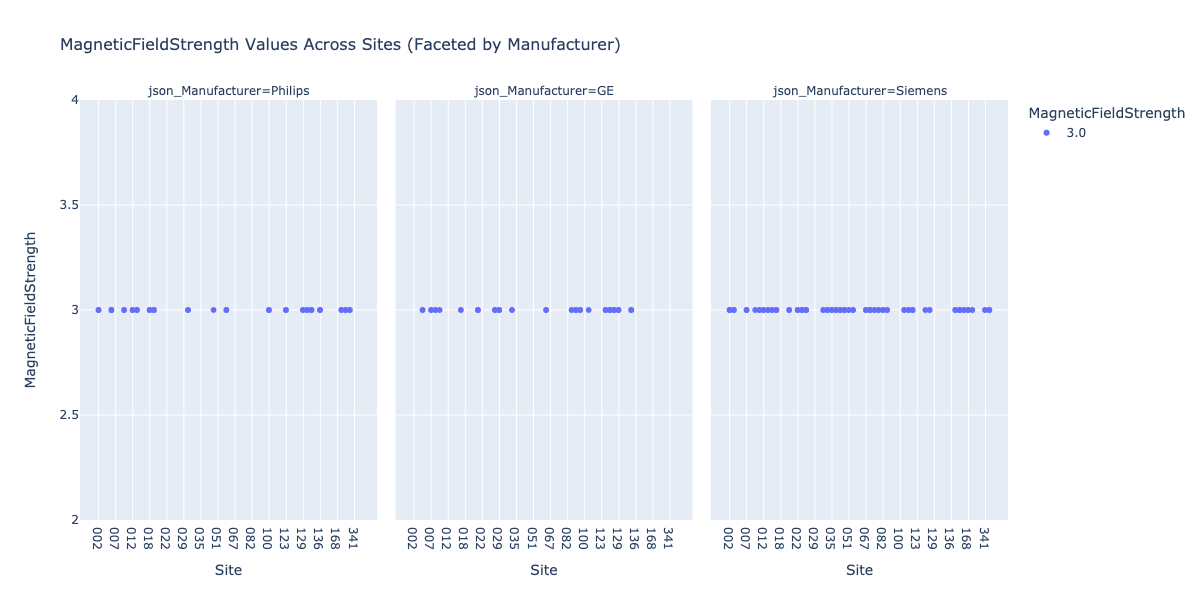

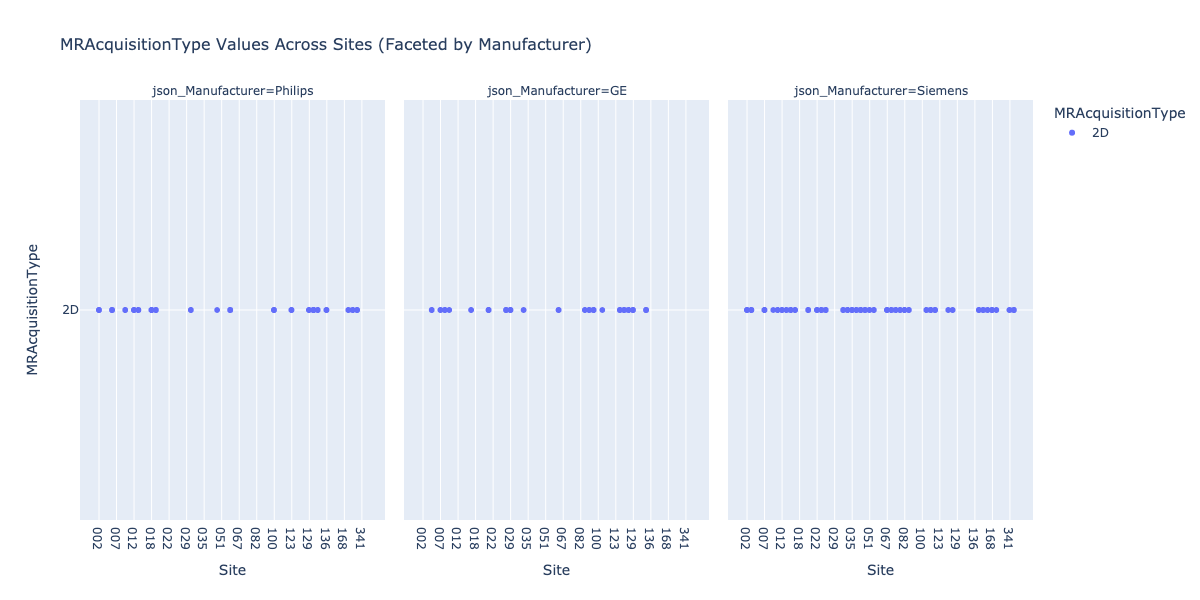

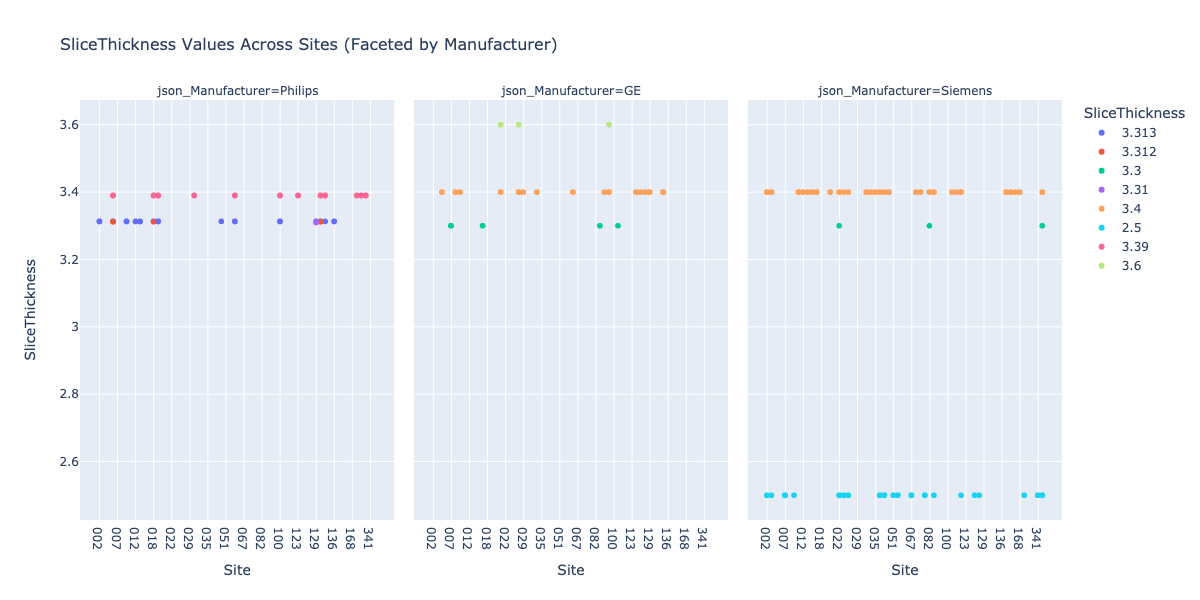

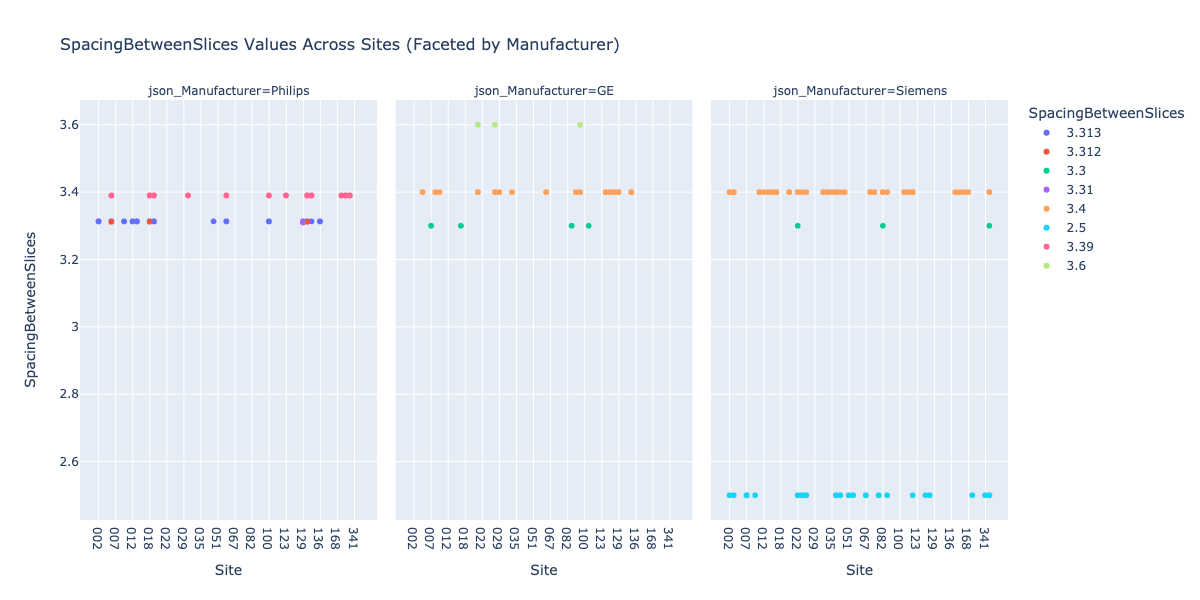

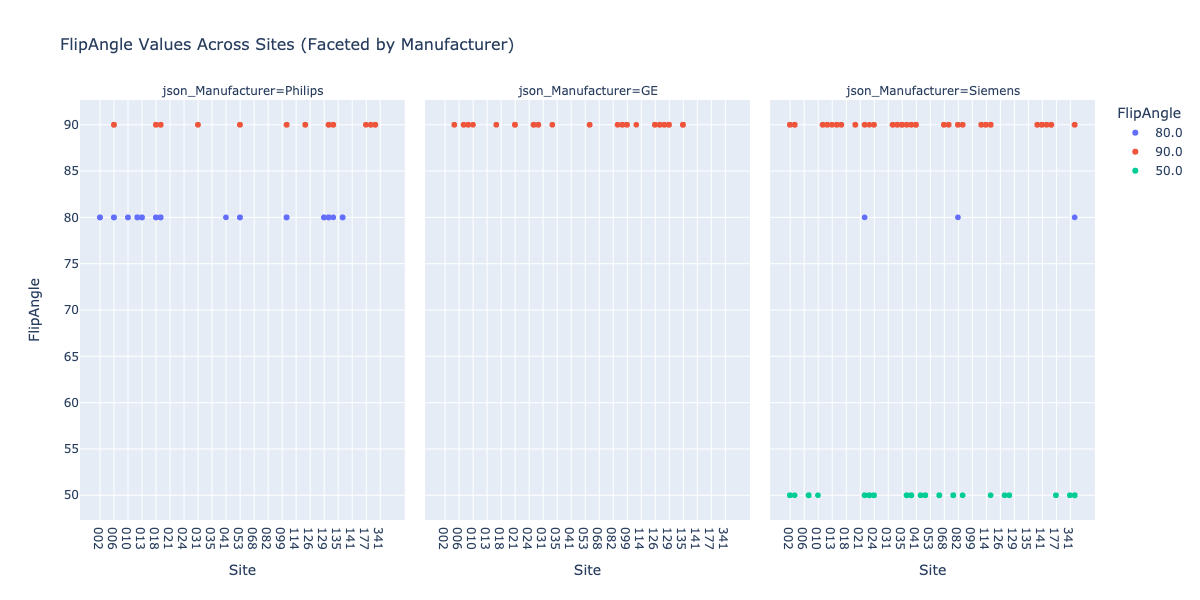

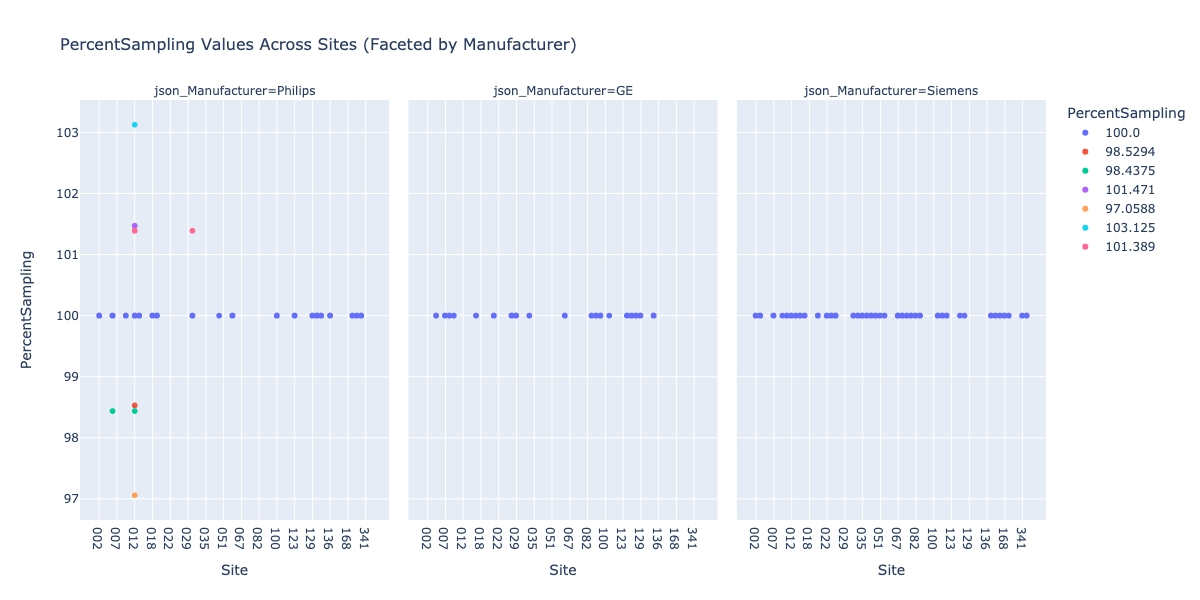

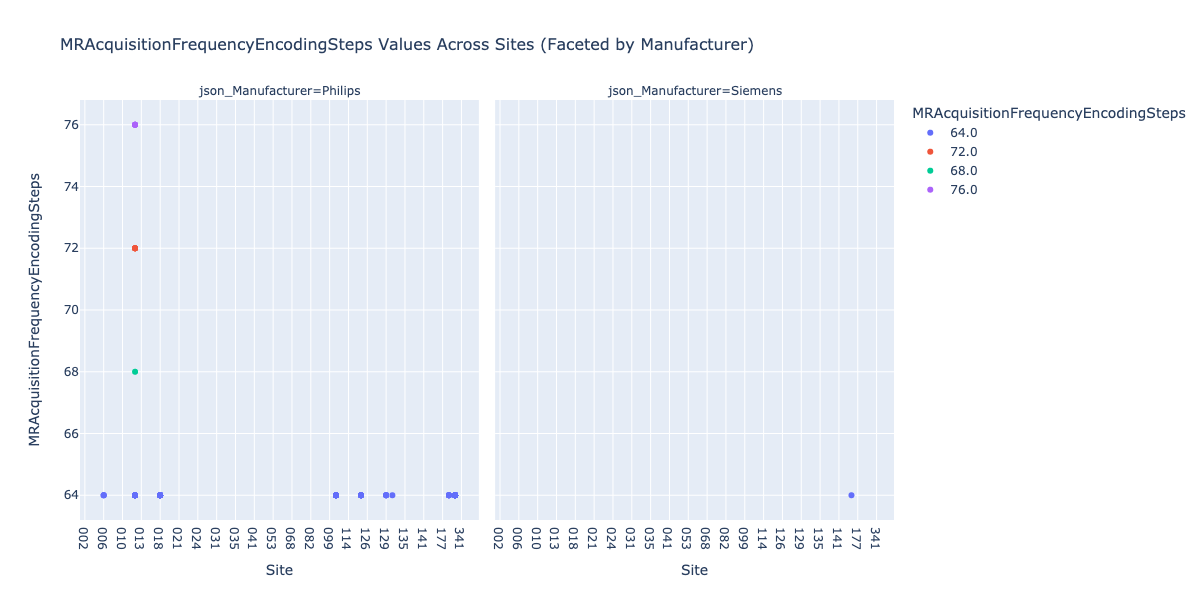

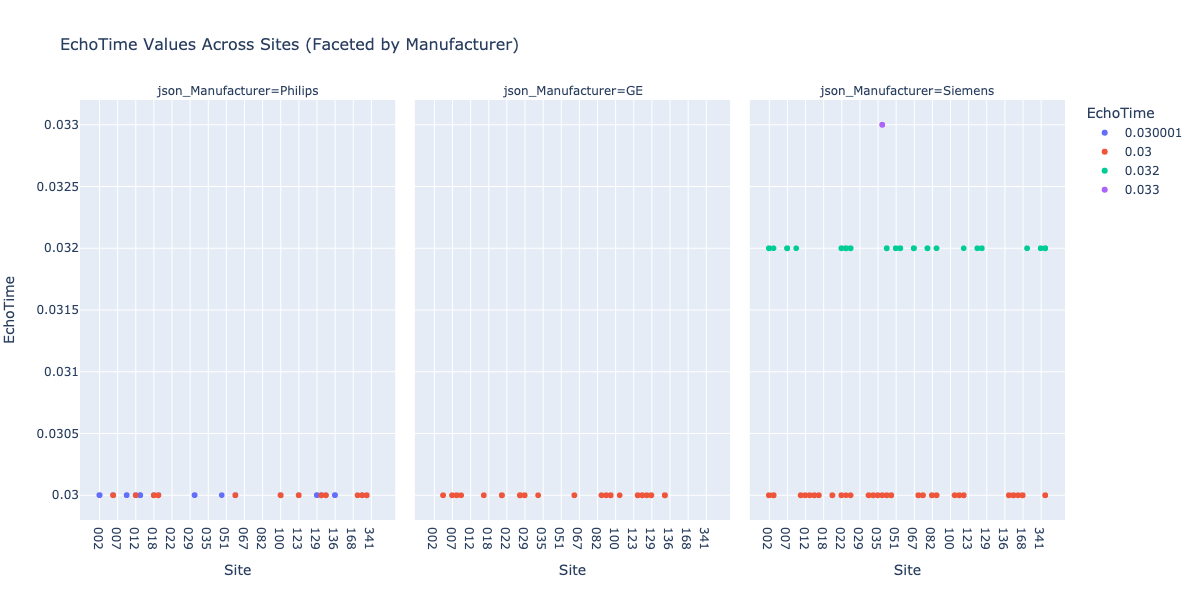

In [48]:
report.render_all_final_plots(produce_html=False) # True will save an interactive plot as an HTML file

## 8. User Notes & Additional Analysis

This section is intentionally left open for users to include any additional comments, observations, or exploratory analyses beyond the core quality control pipeline.  
You may use it to:

- Annotate specific sessions or sites for further investigation
- Summarize patterns noticed during manual review
- Propose alternative heuristics or thresholds
- Attach exploratory plots, modeling results, or notes from collaborators

![Scan Depth Plot](https://github.com/zzahidiu/assets/blob/main/ADNI_report/scandepth_unfiltered.png?raw=true)

The following four sessions were **flagged by the `filter_low_scan_depth` heuristic** for having ScanDepth values just below the 155mm threshold. These points have been **circled in the `scandepth_unfiltered.png` plot** for visual reference. Further manual review will be conducted to determine whether they warrant inclusion despite falling slightly below the cutoff.

| Image_ID | ScanDepth (mm) |
|----------|----------------|
| 661549   | 151.80         |
| 232243   | 149.08         |
| 694259   | 145.20         |
| 925542   | 146.20         |

### 🧠 Image: 661549 – **Scan Depth: 151.80** ❌ ?

![661549](https://github.com/zzahidiu/assets/blob/main/ADNI_report/661549.png?raw=true)

> We see banding artifacts in the sagittal view. We hope `fMRIPrep` or our post-processing heuristics will pick up on this and exclude it.  
> We will check back on it afterwards.  
>  
> **Note:** This might just be isolated motion artifact, so we may not need to throw out the entire session.

---

### 🧠 Image: 232243 – **Scan Depth: 149.08**

![232243](https://github.com/zzahidiu/assets/blob/main/ADNI_report/232243.png?raw=true)

> Field of view (FoV) looks good. It may just be the subject has a small head.  
> At this time, **we are not dropping this session.**

---

### 🧠 Image: 694259 – **Scan Depth: 145.20** ❌

![694259](https://github.com/zzahidiu/assets/blob/main/ADNI_report/694259.png?raw=true)

> The cerebellum is cut off.  
> We can catch this during post-processing using the FreeSurfer segmentation (`aparc`/`aseg`) in native space,  
> and flag based on the number of non-background voxels.  
> _(We believe background = 0, but this should be verified.)_

---

### 🧠 Image: 925542 – **Scan Depth: 146.20**

![925542](https://github.com/zzahidiu/assets/blob/main/ADNI_report/925542.png?raw=true)

> Everything looks good.  
> No visible artifacts or structural issues—**we are keeping this session.**

### Scan Duration Review

![Scan Duration Plot](https://github.com/zzahidiu/assets/blob/main/ADNI_report/duration_unfiltered.png?raw=true)

The following two sessions were **flagged by the `filter_short_duration` heuristic** due to having extremely low or questionable numbers of volumes, despite acceptable TR values. These sessions are highlighted in the `duration_unfiltered.png` plot above.

| Image_ID | Site  | Volumes | Notes                                   |
|----------|-------|---------|-----------------------------------------|
| 1228312  | 007   | 511     | **Extremely low scan duration for number of volumes — removed.** |
| 958730   | 024   | 108     | Borderline case — flagged for review of other sessions at Site 024. |

While the session from Site 007 was clearly below acceptable thresholds and removed from the dataset, the session from Site 024 requires additional context. To evaluate whether it represents a legitimate scan or a protocol deviation, we reviewed the **volume distribution across all 32 sessions from Site 024**:

- **Mean volumes:** 705  
- **Median volumes:** 976  
- **Standard deviation:** 380  
- **Minimum volumes:** 108  
- **25th percentile:** 197  
- **75th percentile:** 976  

Given that **most Site 024 sessions cluster around 976 volumes** and the 25th percentile is nearly double the 108-volume session, the flagged session **appears to be an outlier**. Further manual inspection or cross-referencing with acquisition metadata is recommended to determine whether it should be excluded.

In [ ]:
import ast

# Make a copy and parse nifti_dim if needed
df = report.df_current.copy()
df["Site"] = df["Subject_ID"].astype(str).str[:3]

# Parse nifti_dim field if it's still in string form
if isinstance(df["nifti_dim"].dropna().iloc[0], str):
    df["nifti_dim"] = df["nifti_dim"].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else [None]*8)

# Extract n_volumes from 5th position in nifti_dim
df["n_volumes"] = df["nifti_dim"].apply(lambda x: x[4] if isinstance(x, list) and len(x) > 4 else None)

# Filter to Site 024 and drop missing values
site_024 = df[df["Site"] == "024"]
site_024_valid = site_024[site_024["n_volumes"].notna()]

# Display stats
print("Site 024 n_volumes statistics:")
print(site_024_valid["n_volumes"].describe())

In [ ]:
from plots import render_total_duration_plot
# render_total_duration_plot(report.df_current)
render_total_duration_plot(report.phase_checkpoints[0])